In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from statistics import mean
import joblib
from utils import *
sns.set_theme()

In [2]:
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")
stateless_df = stateless_df.fillna("")

## Building Text Features

In [3]:
def three_char_sld(x):
    if len(x) == 3 and x.isnumeric():
        return int(x)
    else:
        return -1
stateless_df["sld_three_char"] = stateless_df["sld"].apply(three_char_sld)
stateless_df["longest_word_islower"] = stateless_df["longest_word"].apply(lambda x: str(x).islower())
stateless_df["longest_word_isupper"] = stateless_df["longest_word"].apply(lambda x: str(x).isupper())
stateless_df["longest_word_isnumeric"] = stateless_df["longest_word"].apply(lambda x: str(x).isnumeric())
stateless_df["longest_word_isalnum"] = stateless_df["longest_word"].apply(lambda x: str(x).isalnum())
stateless_df["sld_islower"] = stateless_df["sld"].apply(lambda x: str(x).islower())
stateless_df["sld_isupper"] = stateless_df["sld"].apply(lambda x: str(x).isupper())
stateless_df["sld_isnumeric"] = stateless_df["sld"].apply(lambda x: str(x).isnumeric())
stateless_df["sld_isalnum"] = stateless_df["sld"].apply(lambda x: str(x).isalnum())
stateless_df

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,...,origin,sld_three_char,longest_word_islower,longest_word_isupper,longest_word_isnumeric,longest_word_isalnum,sld_islower,sld_isupper,sld_isnumeric,sld_isalnum
0,2020-11-20 13:58:38.988039,26,9,0,10,10,2.742338,6,6,7,...,only-benign,192,False,False,True,True,False,False,True,True
1,2020-11-20 13:58:39.398160,26,9,0,10,10,2.742338,6,6,7,...,only-benign,192,False,False,True,True,False,False,True,True
2,2020-11-20 13:58:39.990691,27,10,0,10,11,2.767195,6,6,7,...,only-benign,192,False,False,True,True,False,False,True,True
3,2020-11-20 13:58:40.400893,27,10,0,10,11,2.767195,6,6,7,...,only-benign,192,False,False,True,True,False,False,True,True
4,2020-11-20 13:58:41.636293,24,7,0,10,8,2.054029,6,6,7,...,only-benign,224,False,False,True,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757206,2020-11-24 23:16:24.708760,24,7,0,10,8,2.054029,6,6,7,...,heavy-attack,224,False,False,True,True,False,False,True,True
757207,2020-11-24 23:16:25.121017,27,10,0,10,11,2.570417,6,6,7,...,heavy-attack,192,False,False,True,True,False,False,True,True
757208,2020-11-24 23:16:25.531377,27,10,0,10,11,2.570417,6,6,7,...,heavy-attack,192,False,False,True,True,False,False,True,True
757209,2020-11-24 23:16:25.943739,27,10,0,10,11,2.570417,6,6,7,...,heavy-attack,192,False,False,True,True,False,False,True,True


# ANOVA to reduce features

In [4]:
print("number of numeric columns: ", len([col for col in stateless_df.columns if col not in ["timestamp", "longest_word", "longest_word_single_char", "sld_three_char", "sld", "subdomain", 'original_index', 'data_type', 'attack', 'origin']]))
print("number of categorical columns: ", len(["longest_word", "longest_word_single_char", "sld_three_char", "sld"]))

number of numeric columns:  19
number of categorical columns:  4


## Reduce numeric features:

In [5]:
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns if col not in ["timestamp", "longest_word", "longest_word_single_char", "sld_three_char", "sld", "subdomain", "Predictions", 'original_index', 'data_type', 'attack', 'origin']]]
y = stateless_df["attack"]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    selector = SelectKBest(f_classif, k=10)
    selector.fit(X_train, y_train)
    cols = selector.get_support(indices=True)
    #print(cols)

In [6]:
print("Accepted Features:")
print(selector.get_feature_names_out())


Accepted Features:
['FQDN_count' 'subdomain_length' 'lower' 'numeric' 'special' 'labels'
 'longest_word_islower' 'longest_word_isnumeric' 'sld_islower'
 'sld_isnumeric']


In [7]:
print("The features that are rejected are: ", [col for col in X.columns if col not in selector.get_feature_names_out()])

The features that are rejected are:  ['upper', 'entropy', 'labels_max', 'labels_average', 'len', 'longest_word_isupper', 'longest_word_isalnum', 'sld_isupper', 'sld_isalnum']


In [8]:
print("p-values of all features:")
print(selector.pvalues_)

p-values of all features:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.77496024e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


# Logistic Regression:

Train Accuracy: 0.7520304803158965
Test Accuracy: 0.7519264673837681
Total time elapsed for building new features: 0.15
Total time elapsed for prediction: 0.15
Train Accuracy: 0.7558772403341868
Test Accuracy: 0.7357404154725902
Total time elapsed for building new features: 0.20
Total time elapsed for prediction: 0.16
Train Accuracy: 0.7493747616665759
Test Accuracy: 0.7617767858321998
Total time elapsed for building new features: 0.16
Total time elapsed for prediction: 0.17
Train Accuracy: 0.749066063136278
Test Accuracy: 0.7629785660516898
Total time elapsed for building new features: 0.15
Total time elapsed for prediction: 0.16
Train Accuracy: 0.7530940011786671
Test Accuracy: 0.746899803224997
Total time elapsed for building new features: 0.16
Total time elapsed for prediction: 0.15


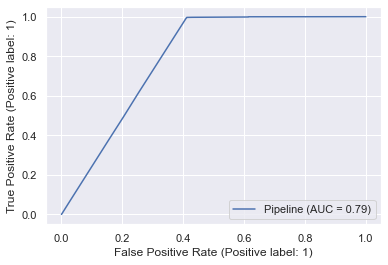

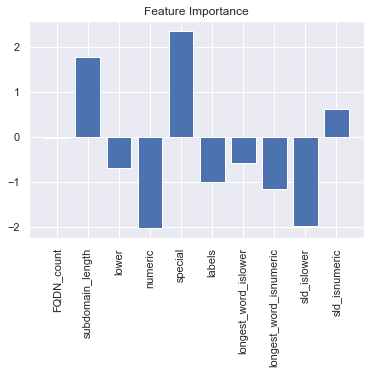

In [9]:

skf = StratifiedKFold(n_splits=5)
#stateless_df = pd.read_csv("stateless.csv")
#stateless_df = stateless_df.fillna("")
stateless_df["Predictions"] = 0
#features_to_use_directly = [col for col in stateless_df.columns if col in selector.get_feature_names_out()]
#features_to_compute = [feature for feature in selector.get_feature_names_out() if feature not in features_to_use_directly]
X = stateless_df[[col for col in selector.get_feature_names_out() if not col.startswith("longest_word") and not col.startswith("sld")]+ ["sld", "longest_word"]]
y = stateless_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    
    
    X_train["longest_word_islower"] = X_train["longest_word"].apply(lambda x: str(x).islower())
    X_train["longest_word_isnumeric"] = X_train["longest_word"].apply(lambda x: str(x).isnumeric())
    X_train["sld_islower"] = X_train["sld"].apply(lambda x: str(x).islower())
    X_train["sld_isnumeric"] = X_train["sld"].apply(lambda x: str(x).isnumeric())
    
    transformation_time_start = time.time()
    
    X_test["longest_word_islower"] = X_test["longest_word"].apply(lambda x: str(x).islower())
    X_test["longest_word_isnumeric"] = X_test["longest_word"].apply(lambda x: str(x).isnumeric())
    X_test["sld_islower"] = X_test["sld"].apply(lambda x: str(x).islower())
    X_test["sld_isnumeric"] = X_test["sld"].apply(lambda x: str(x).isnumeric())
    
    transformation_time_end = time.time()
    
    category_pipeline = ColumnTransformer(
    [
     #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('lr', LogisticRegression(random_state=0, max_iter=300))
    ])    
    
    
    
    pipe.fit(X_train, y_train)
    
    
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for building new features: {(transformation_time_end - transformation_time_start):.2f}")
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += ((prediction_time_end - prediction_time_start) + (transformation_time_end - transformation_time_start))
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
importance = pipe["lr"].coef_[0]

plt.bar(selector.get_feature_names_out(), importance)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

In [10]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 1.609
Time to evaluate a single data point: 0.00000212


# Overall Results

In [11]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)


,precision,recall,f1-score,support
0,0.994365,0.597449,0.746422,462858.000000
1,0.611104,0.994676,0.757078,294353.000000
accuracy,0.751864,0.751864,0.751864,0.751864
macro avg,0.802735,0.796063,0.751750,757211.000000
weighted avg,0.845379,0.751864,0.750564,757211.000000


## Light-attack

In [12]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.996655,0.609958,0.756770,60091.000000
1,0.644868,0.997118,0.783210,42683.000000
accuracy,0.770749,0.770749,0.770749,0.770749
macro avg,0.820762,0.803538,0.769990,102774.000000
weighted avg,0.850555,0.770749,0.767750,102774.000000


## Heavy-attack

In [13]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.986990,0.602904,0.748553,181694.00000
1,0.776193,0.994262,0.871798,251670.00000
accuracy,0.830180,0.830180,0.830180,0.83018
macro avg,0.881591,0.798583,0.810175,433364.00000
weighted avg,0.864572,0.830180,0.820126,433364.00000


In [14]:
stateless_df.Predictions.value_counts(normalize=False)

1    479110
0    278101
Name: Predictions, dtype: int64

## RF

Train Accuracy: 0.7526264180346272
Test Accuracy: 0.7524877346592447
Total time elapsed for building new features: 0.17
Total time elapsed for prediction: 7.51
Train Accuracy: 0.7566811771483849
Test Accuracy: 0.7363280992062968
Total time elapsed for building new features: 0.16
Total time elapsed for prediction: 7.77
Train Accuracy: 0.7502315238977234
Test Accuracy: 0.7621663739253312
Total time elapsed for building new features: 0.16
Total time elapsed for prediction: 8.00
Train Accuracy: 0.7498716507447558
Test Accuracy: 0.763625678477569
Total time elapsed for building new features: 0.15
Total time elapsed for prediction: 7.66
Train Accuracy: 0.7537724776276106
Test Accuracy: 0.747989329248161
Total time elapsed for building new features: 0.16
Total time elapsed for prediction: 7.35


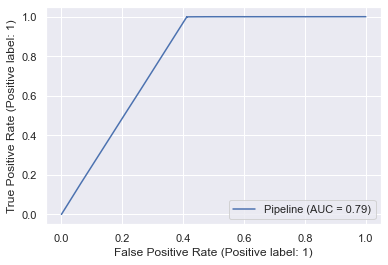

In [16]:

skf = StratifiedKFold(n_splits=5)
#stateless_df = pd.read_csv("stateless.csv")
#stateless_df = stateless_df.fillna("")
stateless_df["Predictions"] = 0
#features_to_use_directly = [col for col in stateless_df.columns if col in selector.get_feature_names_out()]
#features_to_compute = [feature for feature in selector.get_feature_names_out() if feature not in features_to_use_directly]
X = stateless_df[[col for col in selector.get_feature_names_out() if not col.startswith("longest_word") and not col.startswith("sld")]+ ["sld", "longest_word"]]
y = stateless_df["attack"]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    
    
    X_train["longest_word_islower"] = X_train["longest_word"].apply(lambda x: str(x).islower())
    X_train["longest_word_isnumeric"] = X_train["longest_word"].apply(lambda x: str(x).isnumeric())
    X_train["sld_islower"] = X_train["sld"].apply(lambda x: str(x).islower())
    X_train["sld_isnumeric"] = X_train["sld"].apply(lambda x: str(x).isnumeric())
    
    transformation_time_start = time.time()
    
    X_test["longest_word_islower"] = X_test["longest_word"].apply(lambda x: str(x).islower())
    X_test["longest_word_isnumeric"] = X_test["longest_word"].apply(lambda x: str(x).isnumeric())
    X_test["sld_islower"] = X_test["sld"].apply(lambda x: str(x).islower())
    X_test["sld_isnumeric"] = X_test["sld"].apply(lambda x: str(x).isnumeric())
    
    transformation_time_end = time.time()
    
    category_pipeline = ColumnTransformer(
    [
     #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
    ])    
    
    
    
    pipe.fit(X_train, y_train)
    
    
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for building new features: {(transformation_time_end - transformation_time_start):.2f}")
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += ((prediction_time_end - prediction_time_start) + (transformation_time_end - transformation_time_start))
    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
rf_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance


In [17]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 39.082
Time to evaluate a single data point: 0.00005161


### Overall Results

In [18]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)


,precision,recall,f1-score,support
0,0.998660,0.595934,0.746442,462858.000000
1,0.611181,0.998743,0.758313,294353.000000
accuracy,0.752519,0.752519,0.752519,0.752519
macro avg,0.804921,0.797339,0.752377,757211.000000
weighted avg,0.848034,0.752519,0.751056,757211.000000


# Saving the final model trained on all data, in order to use in the robustness evaluation:

## LR

In [17]:



X = stateless_df[[col for col in selector.get_feature_names_out() if not col.startswith("longest_word") and not col.startswith("sld")]+ ["sld", "longest_word"]]
y = stateless_df["attack"]


X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
X["sld_islower"] = X["sld"].apply(lambda x: str(x).islower())
X["sld_isnumeric"] = X["sld"].apply(lambda x: str(x).isnumeric())


category_pipeline = ColumnTransformer(
[
 #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
 ('scaler', StandardScaler(), [col for col in X if col not in ["longest_word", "sld"]])
 ]
)

pipe = Pipeline([
    ('lr', LogisticRegression(random_state=0, max_iter=300))
])    
pipe.fit(category_pipeline.fit_transform(X), y)
joblib.dump(category_pipeline, "lr_optimized_features_column_transformer.pkl")
joblib.dump(pipe, 'lr_optimized_features_model.pkl')



C:\Users\Romario\AppData\Local\Temp\ipykernel_18352\918002686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
C:\Users\Romario\AppData\Local\Temp\ipykernel_18352\918002686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
C:\Users\Romario\AppData\Local\Temp\ipykernel_18352\918002686.py:7: SettingWithCopyWarning: 
A value is trying to be set

['lr_optimized_features_model.pkl']

## RF

In [20]:



X = stateless_df[[col for col in selector.get_feature_names_out() if not col.startswith("longest_word") and not col.startswith("sld")]+ ["sld", "longest_word"]]
y = stateless_df["attack"]


X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
X["sld_islower"] = X["sld"].apply(lambda x: str(x).islower())
X["sld_isnumeric"] = X["sld"].apply(lambda x: str(x).isnumeric())


category_pipeline = ColumnTransformer(
[
 #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
 ('scaler', StandardScaler(), [col for col in X if col not in ["longest_word", "sld"]])
 ]
)

pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=0))
])    
pipe.fit(category_pipeline.fit_transform(X), y)
joblib.dump(category_pipeline, "rf_optimized_features_column_transformer.pkl")
joblib.dump(pipe, 'rf_optimized_features_model.pkl')



C:\Users\Romario\AppData\Local\Temp\ipykernel_18352\2115082065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
C:\Users\Romario\AppData\Local\Temp\ipykernel_18352\2115082065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
C:\Users\Romario\AppData\Local\Temp\ipykernel_18352\2115082065.py:7: SettingWithCopyWarning: 
A value is trying to be 

['rf_optimized_features_model.pkl']

In [24]:
stateless_df["data_type"].value_counts()

benign        462858
text           74581
audio          53413
compressed     45987
video          42383
exe            41079
image          36910
Name: data_type, dtype: int64